In [1]:
# import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Data Prep

In [2]:
path = r'/Users/spencersu/Desktop/Rockdale'

In [3]:
# create a dataframe for word count
wordcnt = pd.read_csv(os.path.join(path, 'Rockdale word count 19-22.csv'))
# remove column: the first column "Unnamed: 0"
wordcnt = wordcnt.iloc[:,1:17]

# wordcnt dataset now has 239253 rows × 16 columns

In [4]:
wordcnt

,Submission Date Date,School Year,School Name,Class Name,Class Subject,Teacher Name [Sensitive],Student ID,Full Name,Enrolled Grade,Lesson ID,Writing Lesson Category,Student Assignment ID,Word Count,Writing Score,Rubric Category,Rubric Category Score
0,2022-01-17,2021-2022,G L Edwards Middle School,"Excel Language Arts 7-23.0120017-711-Larkin, V...",Unknown,Velma Larkin,1151684,Phoenix Johnson,7,26533,Narrative,16211871,24,40,Audience Appropriate Language (Style & Word Ch...,2.0
1,2022-01-17,2021-2022,G L Edwards Middle School,"Excel Language Arts 7-23.0120017-711-Larkin, V...",Unknown,Velma Larkin,1151684,Phoenix Johnson,7,26533,Narrative,16211871,24,40,Conventions Of English,2.0
2,2022-01-17,2021-2022,G L Edwards Middle School,"Excel Language Arts 7-23.0120017-711-Larkin, V...",Unknown,Velma Larkin,1151684,Phoenix Johnson,7,26533,Narrative,16211871,24,40,"Establishing Setting, Point Of View And Charac...",2.0
3,2022-01-17,2021-2022,G L Edwards Middle School,"Excel Language Arts 7-23.0120017-711-Larkin, V...",Unknown,Velma Larkin,1151684,Phoenix Johnson,7,26533,Narrative,16211871,24,40,Narrative Techniques,2.0
4,2022-01-17,2021-2022,G L Edwards Middle School,"Excel Language Arts 7-23.0120017-711-Larkin, V...",Unknown,Velma Larkin,1151684,Phoenix Johnson,7,26533,Narrative,16211871,24,40,Organization,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239248,2019-08-16,2019-2020,Conyers Middle School,"Excel Language Arts 7 - 23.0120017 - Woody, Ke...",Unknown,NaN,721752,Sinai Lugo,8,23345,Narrative,12022015,56,32,Conclusion,1.0
239249,2019-08-16,2019-2020,Conyers Middle School,"Excel Language Arts 7 - 23.0120017 - Woody, Ke...",Unknown,NaN,721752,Sinai Lugo,8,23345,Narrative,12022015,56,32,Conventions of English,1.0
239250,2019-08-16,2019-2020,Conyers Middle School,"Excel Language Arts 7 - 23.0120017 - Woody, Ke...",Unknown,NaN,721752,Sinai Lugo,8,23345,Narrative,12022015,56,32,"Establishing Setting, Voices, and Characters",3.0
239251,2019-08-16,2019-2020,Conyers Middle School,"Excel Language Arts 7 - 23.0120017 - Woody, Ke...",Unknown,NaN,721752,Sinai Lugo,8,23345,Narrative,12022015,56,32,Narrative Techniques,1.0


In [5]:
## change data type into integer: 'Word Count' column

# drop nan for Word Count column
wordcnt2 = wordcnt.dropna(subset=['Word Count'])

# now 'wordcnt' has 229509 rows × 16 columns

# replace ',' with ''
wordcnt2['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
wordcnt2['Word Count'] = wordcnt2['Word Count'].astype(int)

In [6]:
# group by school year, grade level and student name, then take average for all the word count
# group by student assignment ID to remove the duplicates created by rubric category scores

avgcnt = wordcnt2.groupby(['School Year','School Name','Full Name','Enrolled Grade','Student Assignment ID'])['Word Count'].mean()
# change list into dataframe
avgcnt = pd.DataFrame(avgcnt)
avgcnt = avgcnt.reset_index()

In [7]:
# 15044 rows × 5 columns
avgcnt

,School Year,School Name,Full Name,Enrolled Grade,Student Assignment ID,Word Count
0,2019-2020,C J Hicks Elementary School,A'Kiahla Powell,3,12372107,49
1,2019-2020,C J Hicks Elementary School,A'Shiya Jazzmon,5,12732545,154
2,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,12030189,70
3,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,12683749,287
4,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,12995790,173
...,...,...,...,...,...,...
34659,2021-2022,Shoal Creek Elementary School,Zion Davis,3,16202583,6
34660,2021-2022,Shoal Creek Elementary School,Zion Davis,3,16357457,18
34661,2021-2022,Shoal Creek Elementary School,Zyon Carthern,4,16220388,275
34662,2021-2022,Shoal Creek Elementary School,Zyon Carthern,4,16254315,78


In [8]:
# count unique names
avgcnt.groupby('School Year')['Student Assignment ID','Full Name'].nunique()

,Student Assignment ID,Full Name
School Year,,
2019-2020,6374,3761
2020-2021,12648,5429
2021-2022,15642,5755


In [9]:
avgcnt.groupby(['School Year','Enrolled Grade'])['Student Assignment ID','Full Name'].nunique()

Student Assignment ID  Full Name
School Year Enrolled Grade                                  
2019-2020   3                                  68         40
            4                                 288        151
            5                                1443        716
            6                                1095        628
            7                                 985        627
            8                                2495       1614
2020-2021   3                                 125         55
            4                                2063        811
            5                                2165        851
            6                                1606        735
            7                                1941        998
            8                                4748       2001
2021-2022   3                                2445        879
            4                                2684        919
            5                                1902        798
            6                                2464        960
            7                                2894       1141
            8                                3253       1091

In [10]:
# group by and remove assignment ID
avgcnt = avgcnt.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Word Count'].mean()
avgcnt = pd.DataFrame(avgcnt)
avgcnt = avgcnt.reset_index()
avgcnt

,School Year,School Name,Full Name,Enrolled Grade,Word Count
0,2019-2020,C J Hicks Elementary School,A'Kiahla Powell,3,49.000000
1,2019-2020,C J Hicks Elementary School,A'Shiya Jazzmon,5,154.000000
2,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,165.000000
3,2019-2020,C J Hicks Elementary School,Aaric Griffin,5,129.000000
4,2019-2020,C J Hicks Elementary School,Aaron Griffin,7,165.000000
...,...,...,...,...,...
15039,2021-2022,Shoal Creek Elementary School,Zaria Turner,4,500.250000
15040,2021-2022,Shoal Creek Elementary School,Zaryhia Thompson,4,415.500000
15041,2021-2022,Shoal Creek Elementary School,Zion Bautista,4,34.000000
15042,2021-2022,Shoal Creek Elementary School,Zion Davis,3,10.500000


In [11]:
# choose 'enrolled grade' level 3 
avgcnt3 = avgcnt[avgcnt['Enrolled Grade']==3]

# 978 students from grade 3 

# drop column: enrolled grade
avgcnt3.drop('Enrolled Grade',axis=1,inplace=True)

##### remove outlier!!!

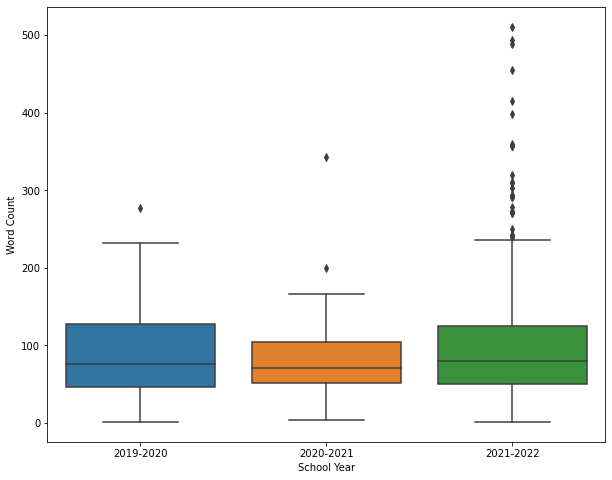

In [12]:
# boxplot: word count vs. school year 
plt.figure(figsize = (10,8))
sns.boxplot(x=avgcnt3['School Year'],y=avgcnt3['Word Count'])
plt.show()

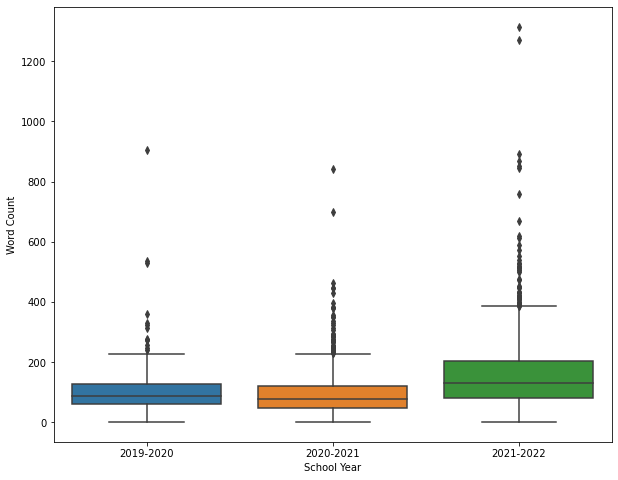

In [13]:
## Grade 4 
# choose 'enrolled grade' level 4 
avgcnt4 = avgcnt[avgcnt['Enrolled Grade']==4]

# 1885 students from grade 4  

# drop column: enrolled grade
avgcnt4.drop('Enrolled Grade',axis=1,inplace=True)

# boxplot: word count vs. school year 
plt.figure(figsize = (10,8))
sns.boxplot(x=avgcnt4['School Year'],y=avgcnt4['Word Count'])
plt.show()

In [14]:
# finish for the other grades 

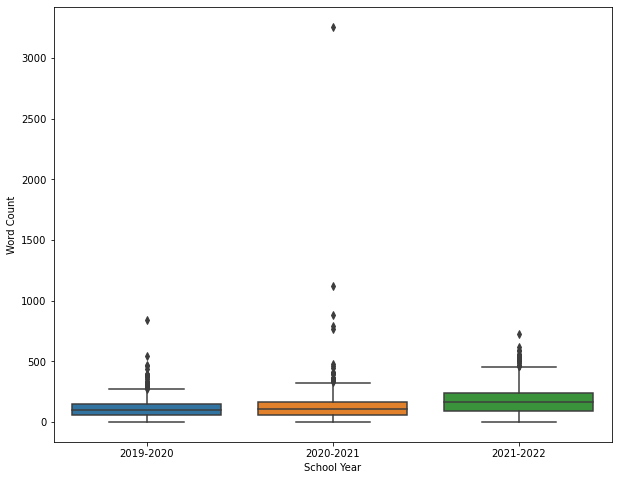

In [15]:
## Grade 5
# choose 'enrolled grade' level 5
avgcnt5 = avgcnt[avgcnt['Enrolled Grade']==5]

# ---- students from grade 4  

# drop column: enrolled grade
avgcnt5.drop('Enrolled Grade',axis=1,inplace=True)

# boxplot: word count vs. school year 
plt.figure(figsize = (10,8))
sns.boxplot(x=avgcnt5['School Year'],y=avgcnt5['Word Count'])
plt.show()

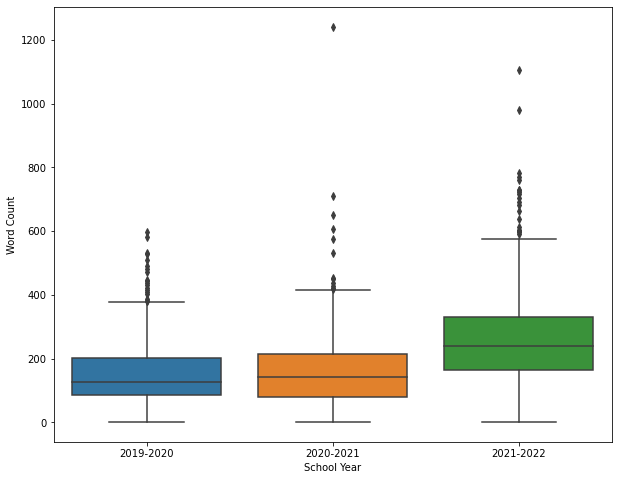

In [16]:
## Grade 6
# choose 'enrolled grade' level 6
avgcnt6 = avgcnt[avgcnt['Enrolled Grade']==6]

# ---- students from grade 6

# drop column: enrolled grade
avgcnt6.drop('Enrolled Grade',axis=1,inplace=True)

# boxplot: word count vs. school year 
plt.figure(figsize = (10,8))
sns.boxplot(x=avgcnt6['School Year'],y=avgcnt6['Word Count'])
plt.show()

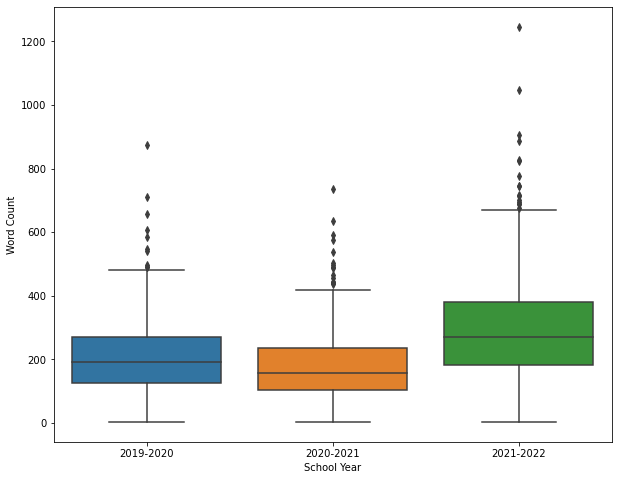

In [17]:
## Grade 7
# choose 'enrolled grade' level 7
avgcnt7 = avgcnt[avgcnt['Enrolled Grade']==7]

# ---- students from grade 7

# drop column: enrolled grade
avgcnt7.drop('Enrolled Grade',axis=1,inplace=True)

# boxplot: word count vs. school year 
plt.figure(figsize = (10,8))
sns.boxplot(x=avgcnt7['School Year'],y=avgcnt7['Word Count'])
plt.show()

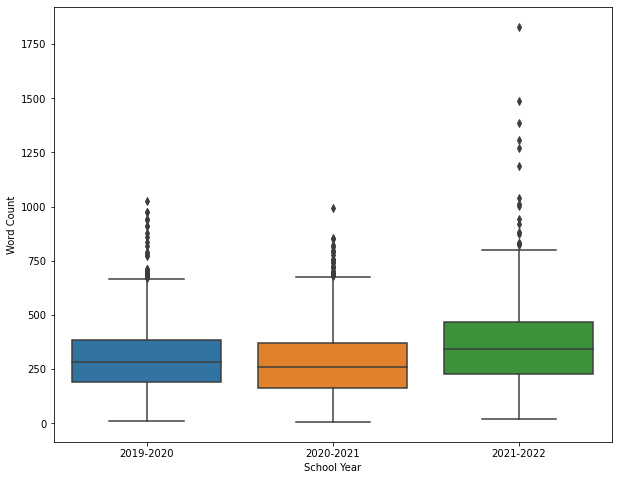

In [18]:
## Grade 8
# choose 'enrolled grade' level 8
avgcnt8 = avgcnt[avgcnt['Enrolled Grade']==8]

# ---- students from grade 8

# drop column: enrolled grade
avgcnt8.drop('Enrolled Grade',axis=1,inplace=True)

# boxplot: word count vs. school year 
plt.figure(figsize = (10,8))
sns.boxplot(x=avgcnt8['School Year'],y=avgcnt8['Word Count'])
plt.show()

In [19]:
avgcnt

,School Year,School Name,Full Name,Enrolled Grade,Word Count
0,2019-2020,C J Hicks Elementary School,A'Kiahla Powell,3,49.000000
1,2019-2020,C J Hicks Elementary School,A'Shiya Jazzmon,5,154.000000
2,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,165.000000
3,2019-2020,C J Hicks Elementary School,Aaric Griffin,5,129.000000
4,2019-2020,C J Hicks Elementary School,Aaron Griffin,7,165.000000
...,...,...,...,...,...
15039,2021-2022,Shoal Creek Elementary School,Zaria Turner,4,500.250000
15040,2021-2022,Shoal Creek Elementary School,Zaryhia Thompson,4,415.500000
15041,2021-2022,Shoal Creek Elementary School,Zion Bautista,4,34.000000
15042,2021-2022,Shoal Creek Elementary School,Zion Davis,3,10.500000


## arrange

In [20]:
# drop column enrolled grade
avgcnt_new = avgcnt.groupby(['School Year','School Name','Full Name'])['Word Count'].mean()
# change list into dataframe
avgcnt_new = pd.DataFrame(avgcnt_new)
avgcnt_new = avgcnt_new.reset_index()

# reshape, pivot
pvt_avgcnt = avgcnt_new.pivot(index=['School Name','Full Name'], columns='School Year', values='Word Count')

In [21]:
# drop all rows that include nan 
pvt_avgcnt = pvt_avgcnt.dropna()

In [22]:
pvt_avgcnt.reset_index()

School Year,School Name,Full Name,2019-2020,2020-2021,2021-2022
0,C J Hicks Elementary School,A'Shiya Jazzmon,154.000000,75.333333,146.75
1,C J Hicks Elementary School,Aaric Griffin,129.000000,93.000000,246.00
2,C J Hicks Elementary School,Aaron Guevara-Torres,70.000000,101.000000,226.25
3,C J Hicks Elementary School,Aiden Nembhard,46.000000,132.666667,55.25
4,C J Hicks Elementary School,Alanys Vazquez Torres,60.333333,215.000000,517.00
...,...,...,...,...,...
643,Shoal Creek Elementary School,Michael Moses,169.333333,213.200000,156.00
644,Shoal Creek Elementary School,Nissa Ramos,327.571429,312.666667,301.00
645,Shoal Creek Elementary School,Shifazehra Momin,293.571429,304.800000,449.00
646,Shoal Creek Elementary School,Stephanie Merino,370.400000,92.000000,24.00


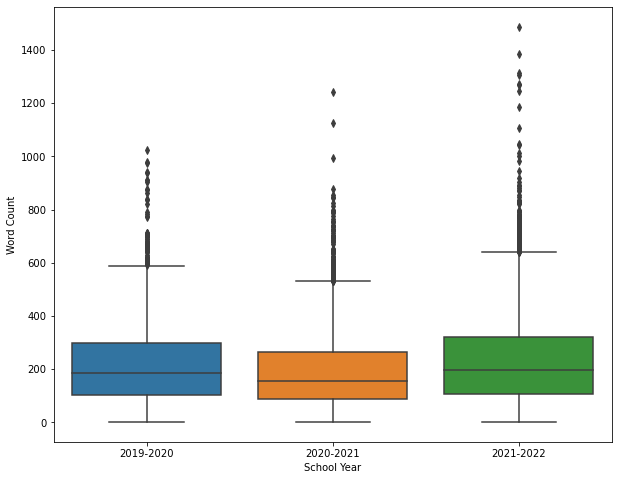

In [23]:
# remove the outliers 
avgcnt_new.drop(avgcnt_new[avgcnt_new['Word Count'] >1600].index, inplace=True)

# boxplot: word count vs. school year 
plt.figure(figsize = (10,8))
sns.boxplot(x=avgcnt_new['School Year'],y=avgcnt_new['Word Count'])
plt.show()

## arrange 

In [24]:
# t-test analysis 
##### add print!
ttest_rel(pvt_avgcnt['2019-2020'], pvt_avgcnt['2020-2021'])

# t value is negative, 2020-2021 has improvement compared to 2019-2020

Ttest_relResult(statistic=-4.488686451021938, pvalue=8.483601615597861e-06)

In [25]:
ttest_rel(pvt_avgcnt['2020-2021'], pvt_avgcnt['2021-2022'])

Ttest_relResult(statistic=-12.27292927546008, pvalue=2.825633823809405e-31)

In [26]:
ttest_rel(pvt_avgcnt['2019-2020'], pvt_avgcnt['2021-2022'])

Ttest_relResult(statistic=-20.476522368084584, pvalue=3.2218537310957026e-72)

## plots

In [27]:
# ## arrange to the top 
# # drop columns: writing scores, lesson category, class subject, class name, submission date, student ID 
# wordcnt_new = wordcnt.drop(['Submission Date Date','Class Name','Class Subject',
#               'Teacher Name [Sensitive]','Student ID','Writing Lesson Category',
#               'Writing Score','Rubric Category','Rubric Category Score'],
#              axis=1, inplace=True)

In [28]:
# drop column enrolled grade
###### make this a function!


wordcnt_new = wordcnt2.groupby(['School Year','School Name','Full Name',
                                'Enrolled Grade','Lesson ID','Student Assignment ID'])['Word Count'].mean()
# change list into dataframe
wordcnt_new = pd.DataFrame(wordcnt_new)
wordcnt_new = wordcnt_new.reset_index()
wordcnt_new

,School Year,School Name,Full Name,Enrolled Grade,Lesson ID,Student Assignment ID,Word Count
0,2019-2020,C J Hicks Elementary School,A'Kiahla Powell,3,20895,12372107,49
1,2019-2020,C J Hicks Elementary School,A'Shiya Jazzmon,5,23329,12732545,154
2,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,21520,12995790,173
3,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,23330,12683749,287
4,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,25208,12030189,70
...,...,...,...,...,...,...,...
34659,2021-2022,Shoal Creek Elementary School,Zion Davis,3,21609,16357457,18
34660,2021-2022,Shoal Creek Elementary School,Zion Davis,3,26808,15917821,12
34661,2021-2022,Shoal Creek Elementary School,Zyon Carthern,4,20988,16254315,78
34662,2021-2022,Shoal Creek Elementary School,Zyon Carthern,4,26926,16220388,275


In [29]:
# arrange 

# create three data frames and merge into one 
a = wordcnt.groupby(['School Year','School Name','Full Name'])['Lesson ID'].count()
b = wordcnt_new.groupby(['School Year','School Name','Full Name'])['Word Count'].mean()
c = wordcnt_new.groupby(['School Year','School Name','Full Name'])['Student Assignment ID'].count()

In [30]:
#####  for loop
num_asgmt_lsn = pd.merge(a,b,on=['School Year','School Name','Full Name'], how='inner')
num_asgmt_lsn = pd.merge(num_asgmt_lsn,c,on=['School Year','School Name','Full Name'], how='inner')

In [31]:
num_asgmt_lsn = num_asgmt_lsn.reset_index()

In [32]:
# test if the number of lessons is the same as the number of assignments 
num_asgmt_lsn['Lesson ID'].equals(num_asgmt_lsn['Student Assignment ID'])

False

In [33]:
# change column name to suggest num of lessons and assignments 
num_asgmt_lsn.rename(columns={num_asgmt_lsn.columns[2]: "Student Name", 
                              num_asgmt_lsn.columns[3]: 'Num of Lessons', 
                              num_asgmt_lsn.columns[5]: 'Num of Assignments Graded'}, inplace = True)

In [34]:
num_asgmt_lsn

,School Year,School Name,Student Name,Num of Lessons,Word Count,Num of Assignments Graded
0,2019-2020,C J Hicks Elementary School,A'Kiahla Powell,7,49.000000,1
1,2019-2020,C J Hicks Elementary School,A'Shiya Jazzmon,6,154.000000,1
2,2019-2020,C J Hicks Elementary School,Aajiah Walker,25,165.000000,4
3,2019-2020,C J Hicks Elementary School,Aaric Griffin,6,129.000000,1
4,2019-2020,C J Hicks Elementary School,Aaron Griffin,13,165.000000,1
...,...,...,...,...,...,...
15026,2021-2022,Shoal Creek Elementary School,Zaria Turner,26,500.250000,4
15027,2021-2022,Shoal Creek Elementary School,Zaryhia Thompson,26,415.500000,4
15028,2021-2022,Shoal Creek Elementary School,Zion Bautista,7,34.000000,1
15029,2021-2022,Shoal Creek Elementary School,Zion Davis,27,10.500000,4


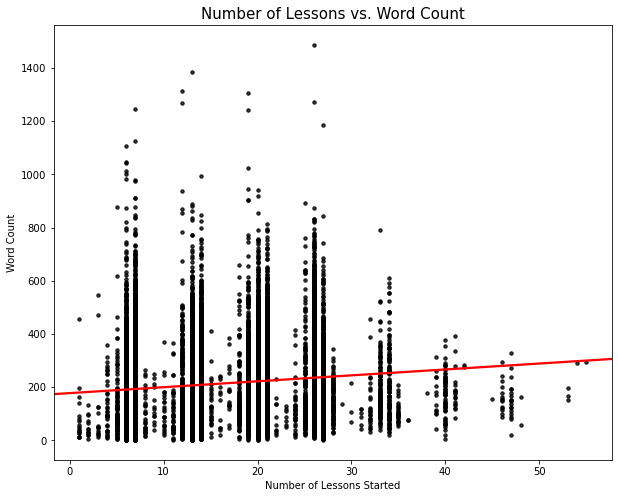

In [35]:
# scatterplot 
##### remove outlier! 
num_asgmt_lsn.drop(num_asgmt_lsn[num_asgmt_lsn['Word Count'] >1600].index, inplace=True)

plt.figure(figsize = (10,8))
sns.regplot(num_asgmt_lsn['Num of Lessons'],num_asgmt_lsn['Word Count'],
            scatter_kws={"color": "black",'s':12}, truncate = False,
            line_kws={"color": "red"}, ci=None)
plt.xlabel('Number of Lessons Started')
plt.ylabel('Word Count')
plt.title("Number of Lessons vs. Word Count", fontsize=15)
plt.show()

## add a correlation for word count vs. scores 

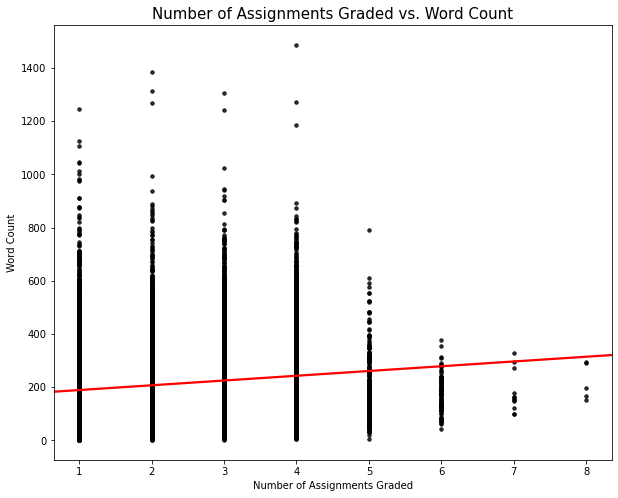

In [36]:
plt.figure(figsize = (10,8))
sns.regplot(num_asgmt_lsn['Num of Assignments Graded'],num_asgmt_lsn['Word Count'],
            scatter_kws={"color": "black",'s':12}, truncate = False,
            line_kws={"color": "red"}, ci=None)
plt.xlabel('Number of Assignments Graded')
plt.ylabel('Word Count')
plt.title("Number of Assignments Graded vs. Word Count", fontsize=15)
plt.show()

<Figure size 720x576 with 0 Axes>

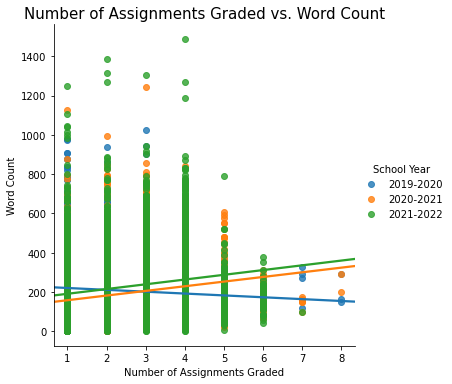

In [37]:
##### change size 
plt.figure(figsize = (10,8))
sns.lmplot(x='Num of Assignments Graded',y='Word Count', data=num_asgmt_lsn,
           truncate = False, hue='School Year',ci=None)
plt.xlabel('Number of Assignments Graded')
plt.ylabel('Word Count')
plt.title("Number of Assignments Graded vs. Word Count", fontsize=15)
plt.show()

<Figure size 720x576 with 0 Axes>

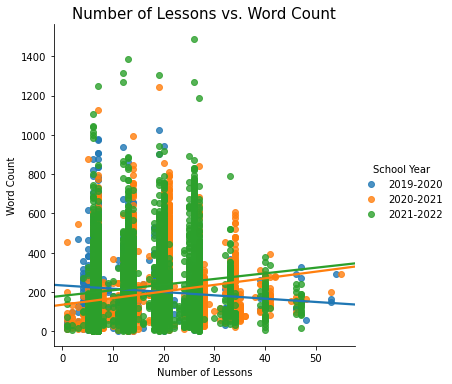

In [38]:
plt.figure(figsize = (10,8))
sns.lmplot(x='Num of Lessons',y='Word Count', data=num_asgmt_lsn,
           truncate = False, hue='School Year',ci=None)
plt.xlabel('Number of Lessons')
plt.ylabel('Word Count')
plt.title("Number of Lessons vs. Word Count", fontsize=15)
plt.show()

## Regression

In [39]:
# add enrolled grade to the regression
a2 = wordcnt.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Lesson ID'].count()
b2 = wordcnt_new.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Word Count'].mean()
c2 = wordcnt_new.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Student Assignment ID'].count()

In [40]:
df_reg = pd.merge(a2,b2,on=['School Year','School Name','Full Name','Enrolled Grade'],how='outer')
df_reg = pd.merge(df_reg, c2, on=['School Year','School Name','Full Name','Enrolled Grade'], how = 'outer')

In [41]:
df_reg = df_reg.reset_index()

In [42]:
df_reg.rename(columns={df_reg.columns[0]: 'school_year', 
                       df_reg.columns[1]: 'school_name',
                       df_reg.columns[2]: 'student_name', 
                       df_reg.columns[3]: 'enrolled_grade',
                       df_reg.columns[4]: 'num_lessons', 
                       df_reg.columns[5]: 'word_count',
                       df_reg.columns[6]: 'num_asgmts'}, inplace = True)

In [43]:
df_reg.drop(df_reg[df_reg['word_count'] >1000].index, inplace=True)

In [44]:
df_reg

,school_year,school_name,student_name,enrolled_grade,num_lessons,word_count,num_asgmts
0,2019-2020,C J Hicks Elementary School,A'Kiahla Powell,3,7,49.000000,1.0
1,2019-2020,C J Hicks Elementary School,A'Shiya Jazzmon,5,6,154.000000,1.0
2,2019-2020,C J Hicks Elementary School,Aajiah Walker,6,25,165.000000,4.0
3,2019-2020,C J Hicks Elementary School,Aaliyah Leverette,7,7,NaN,NaN
4,2019-2020,C J Hicks Elementary School,Aaric Griffin,5,6,129.000000,1.0
...,...,...,...,...,...,...,...
15465,2021-2022,Shoal Creek Elementary School,Zaria Turner,4,26,500.250000,4.0
15466,2021-2022,Shoal Creek Elementary School,Zaryhia Thompson,4,26,415.500000,4.0
15467,2021-2022,Shoal Creek Elementary School,Zion Bautista,4,7,34.000000,1.0
15468,2021-2022,Shoal Creek Elementary School,Zion Davis,3,27,10.500000,4.0


In [45]:
results = smf.ols('word_count ~ num_asgmts + C(enrolled_grade) + C(school_year) + C(school_name)', data=df_reg).fit()
print(results.summary())

# finishing one more assignments will get 19 more words 

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     363.8
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:23:52   Log-Likelihood:                -92873.
No. Observations:               15026   AIC:                         1.858e+05
Df Residuals:                   15001   BIC:                         1.860e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [46]:
# lasso for all variables (class, grade, year, school, etc.), see which has the most effect on word count 

In [47]:
# time series analysis: change the submission date into all first date of the month, then categorize three month
# into one category, then conduct time series analysis to see if the there is any trend for the total data 

In [48]:
df_reg = pd.get_dummies(df_reg, columns=['enrolled_grade','school_name','school_year'])

In [49]:
df_reg = df_reg.dropna()
df_reg

,student_name,num_lessons,word_count,num_asgmts,enrolled_grade_3,enrolled_grade_4,enrolled_grade_5,enrolled_grade_6,enrolled_grade_7,enrolled_grade_8,...,school_name_Lorraine Elementary School,school_name_M G Barksdale Elementary School,school_name_Memorial Middle School,school_name_Peeks Chapel Elementary,school_name_Pine Street Elementary School,school_name_Rockdale Virtual Middle,school_name_Shoal Creek Elementary School,school_year_2019-2020,school_year_2020-2021,school_year_2021-2022
0,A'Kiahla Powell,7,49.000000,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,A'Shiya Jazzmon,6,154.000000,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Aajiah Walker,25,165.000000,4.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Aaric Griffin,6,129.000000,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,Aaron Griffin,13,165.000000,1.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15465,Zaria Turner,26,500.250000,4.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
15466,Zaryhia Thompson,26,415.500000,4.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
15467,Zion Bautista,7,34.000000,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
15468,Zion Davis,27,10.500000,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [50]:
Y = df_reg['word_count']
X = df_reg[df_reg.columns.drop(['word_count','student_name','num_lessons'])]
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

## 19-20 shows negative correlation between word count and num of assignments 
## if 20-21, smallest number of word count 

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     363.8
Date:                Wed, 26 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:23:52   Log-Likelihood:                -92873.
No. Observations:               15026   AIC:                         1.858e+05
Df Residuals:                   15001   BIC:                         1.860e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

## Random Forest Regression

In [61]:
df_rf = wordcnt2.groupby(['School Year','School Name','Lesson ID','Teacher Name [Sensitive]',
                          'Enrolled Grade','Writing Lesson Category',
                          'Student Assignment ID'])['Word Count'].mean()
df_rf = pd.DataFrame(df_rf)
df_rf = df_rf.reset_index()
df_rf

# 17689 rows × 8 columns

,School Year,School Name,Lesson ID,Teacher Name [Sensitive],Enrolled Grade,Writing Lesson Category,Student Assignment ID,Word Count
0,2019-2020,C J Hicks Elementary School,20895,Nicole Holden,4,Argumentative,12758855,28
1,2019-2020,C J Hicks Elementary School,20895,Nicole Holden,4,Argumentative,12758876,54
2,2019-2020,C J Hicks Elementary School,20895,Nicole Holden,4,Argumentative,12761875,93
3,2019-2020,C J Hicks Elementary School,20895,Nicole Holden,4,Argumentative,12761906,8
4,2019-2020,C J Hicks Elementary School,20895,Nicole Holden,4,Argumentative,12762043,61
...,...,...,...,...,...,...,...,...
17684,2021-2022,Shoal Creek Elementary School,29732,Nicole Heyliger,5,Informational,16372975,137
17685,2021-2022,Shoal Creek Elementary School,29732,Nicole Heyliger,5,Informational,16372977,118
17686,2021-2022,Shoal Creek Elementary School,29732,Nicole Heyliger,5,Informational,16372980,101
17687,2021-2022,Shoal Creek Elementary School,29732,Nicole Heyliger,5,Informational,16372981,161


In [62]:
df_rf = pd.get_dummies(df_rf)
df_rf

# 17689 rows × 225 columns

,Lesson ID,Enrolled Grade,Student Assignment ID,Word Count,School Year_2019-2020,School Year_2020-2021,School Year_2021-2022,School Name_Alpha Academy Elementary School,School Name_C J Hicks Elementary School,School Name_Conyers Middle School,...,Teacher Name [Sensitive]_Velma Larkin,Teacher Name [Sensitive]_Veronica Burke,Teacher Name [Sensitive]_Wendy Morrison,Teacher Name [Sensitive]_Yakisha Hill,Teacher Name [Sensitive]_Yandene Williams,Teacher Name [Sensitive]_Yautalya Williams,Teacher Name [Sensitive]_Zachary Scalf,Writing Lesson Category_Argumentative,Writing Lesson Category_Informational,Writing Lesson Category_Narrative
0,20895,4,12758855,28,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,20895,4,12758876,54,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,20895,4,12761875,93,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,20895,4,12761906,8,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,20895,4,12762043,61,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17684,29732,5,16372975,137,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17685,29732,5,16372977,118,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17686,29732,5,16372980,101,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17687,29732,5,16372981,161,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [63]:
Y_rf = df_rf['Word Count']
X_rf = df_rf[df_rf.columns.drop(['Word Count'])]

X_train, X_test, y_train, y_test = train_test_split(X_rf,Y_rf,test_size=0.2)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print('Training RMSE:', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('Training R Squared:', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Testing R Squared:',r2_score(y_test, pred_test_rf))

# training set R Squared is good, but training set and testing set has a huge difference 

Training RMSE: 61.99663864405337
Training R Squared: 0.8975506134976949
Testing RMSE: 169.46869295806755
Testing R Squared: 0.23132923274453454
